In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from xgboost import XGBClassifier

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
text_df = pd.read_csv('./data/preproccessed_data.csv',index_col = 'Unnamed: 0')

In [15]:
text_df.head()

,post_length,text,target,neg,pos,neu,compound,lemma_text
0,708,In Simulacra and Simulation Chapter 1 *Moebius...,1,0.090,0.076,0.834,-0.5913,in simulacrum and simulation chapter 1 moebius...
1,175,Surely in just a absurd world like ours escapi...,1,0.046,0.179,0.775,0.9774,surely in just a absurd world like ours escape...
3,82,"Of course not just physically, but what makes ...",1,0.000,0.042,0.958,0.8397,of course not just physically but what make on...
4,1235,I consider myself an agnostic right now. I am ...,1,0.308,0.083,0.609,-0.9410,i consider myself an agnostic right now i be a...
5,2033,Hello! I am currently working on a term paper ...,1,0.025,0.165,0.810,0.9879,hello i be currently work on a term paper for ...


# Train Test Split

In [4]:
X = text_df.drop(columns = ['target','text'])
y = text_df['target']

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)
X_train

,post_length,neg,pos,neu,compound,lemma_text
5173,3528,0.081,0.093,0.826,0.9184,what an experience i just want to preface by s...
362,179,0.197,0.084,0.719,-0.5994,this be my first time do a soul bomb dealer qu...
2457,4356,0.082,0.051,0.867,-0.9766,firstly let me point out a few thing that i di...
5003,33,0.099,0.142,0.759,0.9360,and if you disagree with it why opinion on dua...
1827,189,0.000,0.279,0.721,0.9176,i love philosophy and i would like to hear abo...
...,...,...,...,...,...,...
502,190,0.078,0.073,0.849,-0.3032,i feel like there be a part of myself that i n...
1811,291,0.040,0.223,0.737,0.9337,i be write an article on the thinker of the en...
10421,859,0.000,0.040,0.960,0.6641,i be read the ego tunnel by thomas metzinger a...
8155,1379,0.041,0.107,0.853,0.9466,figure i would post this because it be be nag ...


# Modeling 

For modeling, there were 5 separate models, with specific parameters GridSearched, to offer a variety of algorithms to the data. TfidfVectorizer was used within the GridSearch in order to remove common words found between both subreddits by optimizing the max_features and max_df parameters. Standard Scaler was also used when needed. First, the baseline accuracy is calculated to compare the models. Accuracy was the metric of choice since false positives or false negatives did not impact the over purpose of the model. 

### Baseline

In [532]:
#askphilosophy = 1
#psychonaut = 0
y.value_counts(normalize = True)

1    0.566428
0    0.433572
Name: target, dtype: float64

### Mulitnomial Naive Bayes
This model strictly used the text feature of the train and test data.

{'mn__alpha': 0.5, 'transformer__tfidfvectorizer__max_df': 0.525, 'transformer__tfidfvectorizer__max_features': 8000}
0.9581890153389411
0.946561108362197


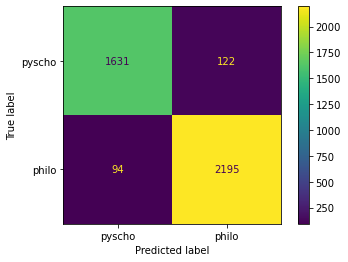

In [440]:
#vectorizer and model used in the grid search
tfid = TfidfVectorizer(stop_words='english',)
mn = MultinomialNB()

#must split vectorized words and numeric data via transformer
transformer = make_column_transformer(
    (tfid,'lemma_text')
    ,remainder='passthrough')

#params for gridsearch
params = {'transformer__tfidfvectorizer__max_features': [8000],
          'transformer__tfidfvectorizer__max_df':[0.525],
          'mn__alpha':[0,.5,1]
         }
#put put everthing together in a pipeline
pipe_nb = Pipeline([
    ('transformer',transformer),Z
    ('mn',mn)])

#run gridsearch with pipe and param grid
grid_nb = GridSearchCV(
    estimator=pipe_nb, 
    param_grid=params,
    scoring='accuracy',
    cv = 5,
    n_jobs=-1)

#fit the model to the text only data because of the MultinomialNB can't have negative numbers
grid_nb.fit(X_train[['lemma_text']],y_train)


#print best params,accuracy scores,and confusion matrix
print(grid_nb.best_params_)
print(grid_nb.score(X_train[['lemma_text']],y_train))
print(grid_nb.score(X_test[['lemma_text']],y_test))
plot_confusion_matrix(grid_nb,X_test[['lemma_text']],y_test,display_labels=['pyscho','philo'])

### Logistic Regression

{'lr__C': 1, 'transformer__tfidfvectorizer__max_df': 0.525, 'transformer__tfidfvectorizer__max_features': 8000}
0.971383803397658
0.9487877288471054


Text(0.5, 1.0, 'Logistic Regression')

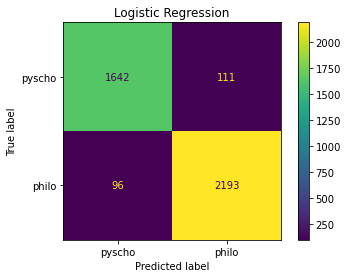

In [449]:
tfid = TfidfVectorizer(stop_words='english',)
lr = LogisticRegression(max_iter=10000,class_weight='balanced')
ss = StandardScaler()

transformer = make_column_transformer(
    (tfid,'lemma_text')
    ,remainder=ss)

pipe_lr = Pipeline([
    ('transformer',transformer),
    ('lr',lr)])

params = {'transformer__tfidfvectorizer__max_features':[8000],
          'transformer__tfidfvectorizer__max_df':[0.525],
          'lr__C':[.1,1,10],
         }

grid_lr = GridSearchCV(
    estimator=pipe_lr, 
    param_grid=params,
    scoring='accuracy',
    cv = 5,
    n_jobs=-1)

grid_lr.fit(X_train,y_train)

print(grid_lr.best_params_)
print(grid_lr.score(X_train,y_train))
print(grid_lr.score(X_test,y_test))
plot_confusion_matrix(grid_lr,X_test,y_test,display_labels=['pyscho','philo'])
plt.title('Logistic Regression')

### K-Nearest Neighbors

{'knn__n_neighbors': 11, 'transformer__tfidfvectorizer__max_df': 0.525, 'transformer__tfidfvectorizer__max_features': 5000}
0.8873494969487052
0.8448787728847106


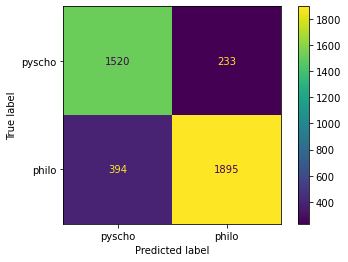

In [420]:
tfid = TfidfVectorizer(stop_words='english',)
knn = KNeighborsClassifier()

transformer = make_column_transformer(
    (tfid,'lemma_text')
    ,remainder=ss)

params = {'transformer__tfidfvectorizer__max_features': [5000,6000,7000,8000,9000,10000],
          'transformer__tfidfvectorizer__max_df': np.linspace(.1,.95,5),
          'knn__n_neighbors':[3,5,7,9,11]
         }


pipe_knn = Pipeline([
    ('transformer',transformer),
    ('knn',knn)])

grid_knn = GridSearchCV(
    estimator=pipe_knn, 
    param_grid=params,
    scoring='accuracy',
    cv = 5,
    n_jobs=-1)

grid_knn.fit(X_train,y_train)

print(grid_knn.best_params_)
print(grid_knn.score(X_train,y_train))
print(grid_knn.score(X_test,y_test))
plot_confusion_matrix(grid_knn,X_test,y_test,display_labels=['pyscho','philo'])
plt.title('K-Nearest Neighbors')

### Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'rf__max_depth': 50, 'rf__n_estimators': 100, 'transformer__tfidfvectorizer__max_df': 0.3125, 'transformer__tfidfvectorizer__max_features': 3000}
0.9840013194788059
0.9319643740722414


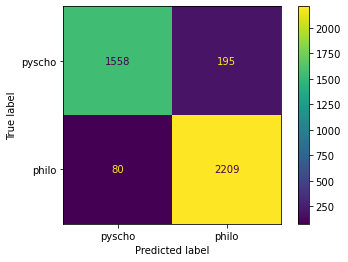

In [434]:
tfid = TfidfVectorizer(stop_words='english',)
rf = RandomForestClassifier()

transformer = make_column_transformer(
    (tfid,'lemma_text')
    ,remainder='passthrough')

params = {'transformer__tfidfvectorizer__max_features': [3000],
          'transformer__tfidfvectorizer__max_df': [0.3125],
          'rf__n_estimators':[100],
          'rf__max_depth':[50]
         }


pipe_rf = Pipeline([
    ('transformer',transformer),
    ('rf',rf)])

grid_rf = GridSearchCV(
    estimator=pipe_rf, 
    param_grid=params,
    scoring='accuracy',
    cv = 5,
    verbose=True,
    n_jobs=-1)

grid_rf.fit(X_train,y_train)

print(grid_rf.best_params_)
print(grid_rf.score(X_train,y_train))
print(grid_rf.score(X_test,y_test))
plot_confusion_matrix(grid_rf,X_test,y_test,display_labels=['pyscho','philo'])
plt.title('Random Forest')

### XGBClassifier

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'transformer__tfidfvectorizer__max_df': 0.3125, 'transformer__tfidfvectorizer__max_features': 6000, 'xgb__learning_rate': 0.5, 'xgb__max_depth': 9, 'xgb__n_estimators': 15}
0.9571994062345374
0.9163780306778823


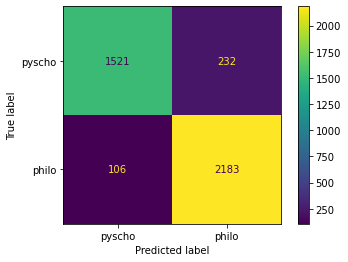

In [441]:
tfid = TfidfVectorizer(stop_words='english',)
xgb = XGBClassifier() 

transformer = make_column_transformer(
    (tfid,'lemma_text')
    ,remainder='passthrough')

params = {'transformer__tfidfvectorizer__max_features': [5000,6000,7000,8000,9000,10000],
          'transformer__tfidfvectorizer__max_df': np.linspace(.1,.95,5),
          'xgb__n_estimators':[15],
          'xgb__max_depth': [9],
          'xgb__learning_rate':[.5]
         }

pipe_xgb = Pipeline([
    ('transformer',transformer),
    ('xgb',xgb)])


grid_xgb = GridSearchCV(
    estimator=pipe_xgb, 
    param_grid=params,
    scoring='accuracy',
    cv = 5,
    verbose=True,
    n_jobs=-1)

grid_xgb.fit(X_train,y_train)

print(grid_xgb.best_params_)
print(grid_xgb.score(X_train,y_train))
print(grid_xgb.score(X_test,y_test))
plot_confusion_matrix(grid_xgb,X_test,y_test,display_labels=['pyscho','philo'])
plt.title('XGBClassifier')

# Conclusions

Out of all the models, using gridsearch, logistic regression returned the best accuracy with no signs of overfitting the training data. To further improve the models, a more robust parameter searching function may help further improve the modeling like BayesSearch or RandomizedSearch. Increasing possible features may also help improve the accuracy. 

The feature importance shows the most influential words for predicting each subreddit. Because of the integreated pipeline and gridsearch, retriving the attributes from the transformer and model took some effort. Below is the collection of the top 20 words with the assigned coefficents from the logistic regression model. 

## askphilosophy words

In [510]:
philosophy_features = []


for c,w in word_features[-20:]:
    features = {}
    features['word'] = w
    features['coef'] = c
    philosophy_features.append(features)

askphilosophy_top20 = pd.DataFrame(philosophy_features)
askphilosophy_top20 = askphilosophy_top20.sort_values(by='coef',ascending=False).set_index('word')
askphilosophy_top20['log_odds'] = askphilosophy_top20['coef'].apply(np.exp)
askphilosophy_top20

,coef,log_odds
word,,
philosophy,9.607795,14880.318821
philosopher,5.744352,312.420977
argument,5.659922,287.126206
philosophical,4.662506,105.901179
moral,3.637018,37.978407
question,3.359590,28.777401
read,3.259728,26.042452
example,3.215845,24.924343
say,3.203940,24.629381


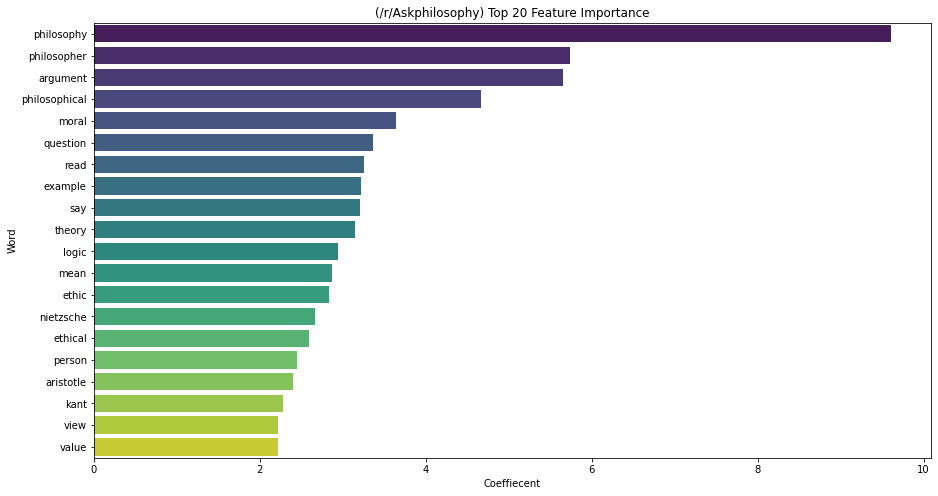

In [529]:
plt.figure(figsize=(15,8))
sns.barplot(data = askphilosophy_top20,
            y=askphilosophy_top20.index,
            x=askphilosophy_top20['coef'],
            orient='h',
            palette='viridis')

plt.ylabel('Word')
plt.xlabel('Coeffiecent')
plt.title('(/r/Askphilosophy) Top 20 Feature Importance');
plt.savefig('./plots/askphilosophy_top20.jpeg',dpi=300, bbox_inches = "tight")

## Psychonaut words

In [511]:
psychonaut_features = []

for w,c in word_features[:20]:
    features = {}
    features['word'] = c
    features['coef'] = w
    sychonaut.append(features)
    
psychonaut_top20 = pd.DataFrame(psychonaut_features).set_index('word')
psychonaut_top20['log_odds'] = psychonaut_top20['coef'].apply(np.exp)
psychonaut_top20

,coef,log_odds
word,,
trip,-8.831131,0.000146
psychedelics,-6.987996,0.000923
psychedelic,-5.029007,0.006545
lsd,-4.796542,0.008258
dmt,-4.486111,0.011264
shrooms,-4.434908,0.011856
experience,-4.417880,0.012060
mushroom,-4.348023,0.012932
ego,-4.287755,0.013736


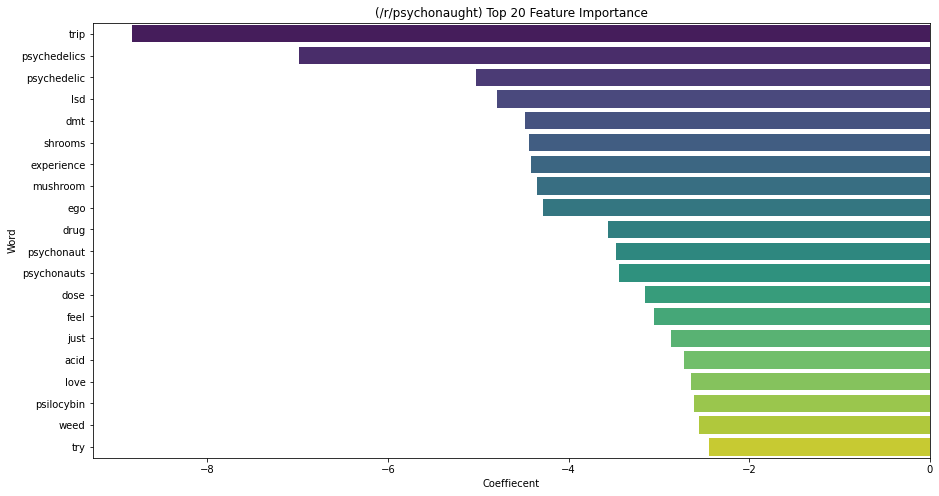

In [528]:
plt.figure(figsize=(15,8))
sns.barplot(data = psychonaut_top20,
            y=psychonaut_top20.index,
            x=psychonaut_top20['coef'],
            orient='h',
            palette='viridis')

plt.ylabel('Word')
plt.xlabel('Coeffiecent')
plt.title('(/r/psychonaut) Top 20 Feature Importance');

plt.savefig('./plots/psychonaut_top20.jpeg',dpi=300, bbox_inches = "tight")